In [108]:
%reset -f
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append(os.path.join(os.path.pardir, 'code'))

import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import pynumdiff
import figurefirst as fifi
import figure_functions as ff
import pickle
import scipy
import pandas as pd

from utils import list_of_dicts_to_dict_of_lists

from simulator import FlyWindDynamics

pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initialize simulator

In [109]:
# Simulator parameters
m = 0.01
I = 0.05
C_phi = 1.0
C_para = 1.0
C_perp = 1.0

In [110]:
# Simulator settings
polar_mode = True  # if True, then use the polar representation of ground speed for the intial conditions & inputs
control_mode = 'no_dynamics_control'  # set how the inputs are chosen: 'open_loop', 'no_dynamics_control', or 'hover'
update_every_step = True  # if True, then update controls for every time-step chosen by the ODE solver

In [111]:
# Make simulator object
simulator = FlyWindDynamics(polar_mode=polar_mode, control_mode=control_mode, update_every_step=update_every_step,
                            m=m, I=I, C_phi=C_phi, C_para=C_para, C_perp=C_perp)

### Set simulation time

In [112]:
# Simulation time
fs = 50.0  # sampling frequency [hz]
T = 0.2  # simulation time [s]
dt = 1 / fs  # sampling time [s]
tsim = np.arange(0, T + dt, dt).T  # simulation time vector [s]

### Set control commands

In [113]:
# Wind
w = 0.2 * np.ones_like(tsim)
zeta = 0.0 * np.ones_like(tsim)

wdot = pynumdiff.finite_difference.second_order(w, dt)[1]
zetadot = pynumdiff.finite_difference.second_order(zeta, dt)[1]

# Thrust
r_g = 0.0 * np.ones_like(tsim)
r_psi = 0 * (np.pi/2) * np.ones_like(tsim)

# Heading
phi = (np.pi/2)*np.cos(2*np.pi*4*tsim)
phidot = pynumdiff.finite_difference.second_order(phi, dt)[1]
phiddot = pynumdiff.finite_difference.second_order(phidot, dt)[1]

r_phi = phiddot

In [114]:
# Collect inputs
usim = np.stack([r_g, r_psi, r_phi, wdot, zetadot], axis=1)

### Set initial conditions

In [115]:
g0 = 1.0  # ground speed
psi0 = 0.0  # ground speed angle
phi0 = phi[0]  # heading in global frame
phidot0 = phidot[0]  # angular velocity
w0 = w[0]  # wind speed
zeta0 = zeta[0] # wind direction in global frame

In [116]:
# Collect initial conditions
x0 = np.array([g0, psi0, phi0, phidot0, w0, zeta0])

### Run simulation

#### Offline simulation

In [117]:
# Simulate system
x_solve, sim_data_offline, t_solve = simulator.odeint_simulate(x0, tsim, usim)

#### Real-time simulation

In [118]:
t = 0  # start time, we already know state at t=0
T = tsim[-1]  # end time
x = x0  # start with prescribed initial state
n = 1  # counter, start at n=1 for t=dt not t=0 (not needed for actual real-time)

# Reset simulator
simulator.reset()

# Run once at time 0 to get initial data
x, data = simulator.odeint_step(x0=x, dt=0.0)

# Create list to store simulation data
sim_data = [data]

# Run simulator in increments of dt
while simulator.t < T:
    u = np.squeeze(np.array([r_g[n], r_psi[n], r_phi[n], wdot[n], zetadot[n]]))
    x, data = simulator.odeint_step(dt=dt, usim=u, polar=True)
    
    sim_data.append(data)
    n = n + 1

print('Done')

sim_data = list_of_dicts_to_dict_of_lists(sim_data, make_array=True)

Done


### Compare offline vs real-time

In [119]:
df_offline = round(pd.DataFrame(sim_data_offline), 5)
df_offline

,time,v_para,v_perp,g,psi,phi,phidot,w,zeta,wdot,zetadot,a_para,a_perp,a,gamma,xvel,yvel,xpos,ypos,u_para,u_perp,u_phi,u_g,u_psi
0,0.00,1.0,0.0,1.0,0.0,1.57080,-1.20166,0.2,0.0,0.0,0.0,1.00000,0.20000,1.01980,0.19740,0.00000,1.00000,0.00000,0.00000,1.00000,0.18798,-1.20166,1.01752,0.18581
1,0.02,1.0,0.0,1.0,0.0,1.39304,-16.57418,0.2,0.0,0.0,0.0,0.96464,0.19685,0.98452,0.20130,0.17682,0.98424,0.00177,0.01984,0.96464,0.03111,-55.00549,0.96514,0.03224
2,0.04,1.0,0.0,1.0,0.0,0.96388,-26.34126,0.2,0.0,0.0,0.0,0.88593,0.16428,0.90104,0.18335,0.57033,0.82141,0.00924,0.03790,0.88593,-0.09913,-50.75893,0.89146,-0.11143
3,0.06,1.0,0.0,1.0,0.0,0.42561,-27.48580,0.2,0.0,0.0,0.0,0.81784,0.08258,0.82200,0.10063,0.91079,0.41288,0.02405,0.05024,0.81784,-0.19228,-30.34717,0.84014,-0.23092
4,0.08,1.0,0.0,1.0,0.0,-0.04649,-19.72468,0.2,0.0,0.0,0.0,0.80022,-0.00930,0.80027,-0.01162,0.99892,-0.04648,0.04315,0.05391,0.80022,-0.20654,-0.32188,0.82644,-0.25259
5,0.10,1.0,0.0,1.0,0.0,-0.29352,-4.97789,0.2,0.0,0.0,0.0,0.80855,-0.05786,0.81062,-0.07144,0.95723,-0.28932,0.06271,0.05055,0.80855,-0.10764,31.88910,0.81569,-0.13235
6,0.12,1.0,0.0,1.0,0.0,-0.21223,13.10642,0.2,0.0,0.0,0.0,0.80449,-0.04213,0.80559,-0.05232,0.97756,-0.21064,0.08206,0.04555,0.80449,0.08894,58.31718,0.80939,0.11010
7,0.14,1.0,0.0,1.0,0.0,0.21938,30.05442,0.2,0.0,0.0,0.0,0.80479,0.04352,0.80597,0.05403,0.97603,0.21762,0.10159,0.04562,0.80479,0.34407,72.42442,0.87526,0.40401
8,0.16,1.0,-0.0,1.0,-0.0,0.93665,41.67341,0.2,0.0,0.0,0.0,0.88150,0.16112,0.89611,0.18078,0.59249,0.80558,0.11728,0.05585,0.88150,0.57785,70.72088,1.05402,0.58025
9,0.18,1.0,-0.0,1.0,-0.0,1.82839,47.50022,0.2,0.0,0.0,0.0,1.05095,0.19340,1.06860,0.18199,-0.25475,0.96701,0.12066,0.07358,1.05095,0.66840,62.06725,1.24550,0.56647


In [120]:
df_realtime = np.round(pd.DataFrame(sim_data), 5)
df_realtime

,time,v_para,v_perp,g,psi,phi,phidot,w,zeta,wdot,zetadot,a_para,a_perp,a,gamma,xvel,yvel,xpos,ypos,u_para,u_perp,u_phi,u_g,u_psi
0,0.00,1.0,0.0,1.0,0.0,1.57080,-1.20166,0.2,0.0,0.0,0.0,1.00000,0.20000,1.01980,0.19740,0.00000,1.00000,0.00000,0.00000,1.00000,0.18798,-1.20166,1.01752,0.18581
1,0.02,1.0,0.0,1.0,0.0,1.39304,-16.57418,0.2,0.0,0.0,0.0,0.96464,0.19685,0.98452,0.20130,0.17682,0.98424,0.00177,0.01984,0.96464,0.03111,-55.00549,0.96514,0.03224
2,0.04,1.0,0.0,1.0,0.0,0.96388,-26.34126,0.2,0.0,0.0,0.0,0.88593,0.16428,0.90104,0.18335,0.57033,0.82141,0.00924,0.03790,0.88593,-0.09913,-50.75893,0.89146,-0.11143
3,0.06,1.0,0.0,1.0,0.0,0.42561,-27.48580,0.2,0.0,0.0,0.0,0.81784,0.08258,0.82200,0.10063,0.91079,0.41288,0.02405,0.05024,0.81784,-0.19228,-30.34717,0.84014,-0.23092
4,0.08,1.0,0.0,1.0,0.0,-0.04649,-19.72468,0.2,0.0,0.0,0.0,0.80022,-0.00930,0.80027,-0.01162,0.99892,-0.04648,0.04315,0.05391,0.80022,-0.20654,-0.32188,0.82644,-0.25259
5,0.10,1.0,0.0,1.0,0.0,-0.29352,-4.97789,0.2,0.0,0.0,0.0,0.80855,-0.05786,0.81062,-0.07144,0.95723,-0.28932,0.06271,0.05055,0.80855,-0.10764,31.88910,0.81569,-0.13235
6,0.12,1.0,0.0,1.0,0.0,-0.21223,13.10642,0.2,0.0,0.0,0.0,0.80449,-0.04213,0.80559,-0.05232,0.97756,-0.21064,0.08206,0.04555,0.80449,0.08894,58.31718,0.80939,0.11010
7,0.14,1.0,0.0,1.0,0.0,0.21938,30.05442,0.2,0.0,0.0,0.0,0.80479,0.04352,0.80597,0.05403,0.97603,0.21762,0.10159,0.04562,0.80479,0.34407,72.42442,0.87526,0.40401
8,0.16,1.0,-0.0,1.0,-0.0,0.93665,41.67341,0.2,0.0,0.0,0.0,0.88150,0.16112,0.89611,0.18078,0.59249,0.80558,0.11728,0.05585,0.88150,0.57785,70.72088,1.05402,0.58025
9,0.18,1.0,-0.0,1.0,-0.0,1.82839,47.50022,0.2,0.0,0.0,0.0,1.05095,0.19340,1.06860,0.18199,-0.25475,0.96701,0.12066,0.07358,1.05095,0.66840,62.06725,1.24550,0.56647


In [121]:
df_offline == df_realtime

,time,v_para,v_perp,g,psi,phi,phidot,w,zeta,wdot,zetadot,a_para,a_perp,a,gamma,xvel,yvel,xpos,ypos,u_para,u_perp,u_phi,u_g,u_psi
0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
5,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
6,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
7,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
8,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
9,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


### Plot trajectory

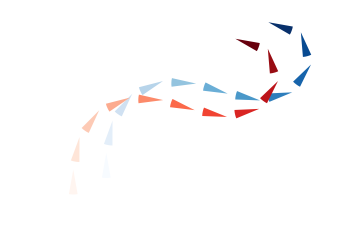

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ff.plot_trajectory(sim_data['xpos'],
                   sim_data['ypos'],
                   sim_data['phi'],
                   color=sim_data['time'],
                   ax=ax,
                   size_radius=0.015,
                   nskip=int(fs/100),
                   colormap='Blues')

offset = [-0.02, -0.01]
ff.plot_trajectory(offset[0] + sim_data_offline['xpos'],
                   offset[1] + sim_data_offline['ypos'],
                   sim_data_offline['phi'],
                   color=sim_data_offline['time'],
                   ax=ax,
                   size_radius=0.015,
                   nskip=int(fs/100),
                   colormap='Reds')

fifi.mpl_functions.adjust_spines(ax, [])

### Save data

In [123]:
savepath = os.path.join(os.path.pardir, 'simulation_data', 'example_no_dynamics_control.pk')

In [124]:
with open(savepath, 'wb') as fp:
    pickle.dump(sim_data, fp)

### Load data

In [125]:
with open(savepath, 'rb') as fp:
    data = pickle.load(fp)